Applying Beam Search: Description: Load a pre-trained LSTM-based NMT model and implement beam search decoding to improve translation quality. Guidelines: GUI is not necessary. It will be evaluated on the basis of accuracy score.

In [ ]:
!pip install -q tensorflow keras

Model is trained. Final Loss: 0.0064, Final Accuracy: 1.0000

Translations and Evaluation:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Input: i love you
Greedy: je t'aime
Beam:   je t'aime
Expected: je t'aime
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Input: how are you
Greedy: comment ça va
Beam:   comment ça va
Expected: comment ça va
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input: this is a book
Greedy: c'est un livre
Beam:   c'est un livre
Expected: c'est un livre
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input: thank you
Greedy: merci
Beam:   merci
Expected: merci
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Input: good morning
Greedy: bonjour
Beam:   bonjour
Expected: bonjour
----------------------------------------


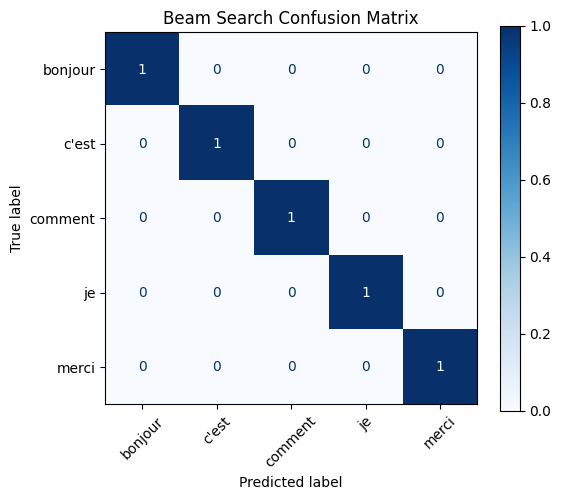

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


eng_sentences = [
    "i love you", "how are you", "this is a book", "thank you", "good morning",
    "good night", "see you soon", "i like books", "this is great", "where is the pen",
    "my teacher", "good evening", "good afternoon", "see you tomorrow", "what is your name",
    "where do you live", "i am hungry", "i am thirsty", "can you help me", "i am learning french",
    "do you understand", "i need water", "i want to eat", "this is delicious", "my name is john",
    "i am a student", "i am from france", "do you have time", "it is raining", "it is cold",
    "i am tired", "let us go", "what time is it", "i love music", "please sit down",
    "open the door", "close the window", "where are you going", "i am at home", "i am busy",
    "call me later", "i am coming", "wait for me", "i am happy", "i am sad",
    "i am angry", "i am scared", "i am excited", "i am bored", "i am ready",
    "i am not ready", "i am lost", "can i help you", "what happened", "don't worry",
    "take care", "be careful", "good luck", "congratulations", "happy birthday",
    "happy new year", "happy anniversary", "see you later", "see you next week", "have a nice day",
    "have a good night", "sweet dreams", "nice to meet you", "i am okay", "i am not well",
    "i am sick", "i have a headache", "i have a fever", "i am going out", "i am coming back",
    "i will call you", "i will help you", "i will try", "i forgot", "i remember",
    "i agree", "i disagree", "i don't know", "i know", "i think so",
    "i don't think so", "maybe", "of course", "no problem", "it's okay",
    "it's not okay", "it's possible", "it's impossible", "i am busy today", "i am free today",
    "i am at work", "i am at school", "i am at the market", "where is the bathroom", "where is the kitchen",
    "where is the bus stop", "where is the station", "where is the shop", "how much is this", "how many",
    "how far is it", "how long will it take", "how do i get there", "can i have this", "can i try",
    "can i see", "can i come in", "can i go out", "please wait", "please come in",
    "please go out", "please listen", "please repeat", "please write it down", "please speak slowly",
    "please help me", "please call me", "please show me", "what do you want", "what do you need",
    "what do you like", "what do you think", "what do you mean", "what is this", "what is that",
    "what is your favorite color", "what is your favorite food", "what is your favorite movie", "who are you", "who is he",
    "who is she", "who is there", "who called", "when will you come", "when will you go",
    "when will we meet", "when is your birthday", "when is the exam", "where are you from", "where is your house",
    "where do you work", "where do you study", "where did you go", "why are you late", "why are you sad",
    "why are you happy", "why not", "why did you do that", "which one", "which way",
    "which color", "which book", "which movie", "whose bag is this", "whose phone is this",
    "whose book is that", "whose pen is this", "whose car is that", "can you come", "can you go",
    "can you do it", "can you tell me", "can you show me", "do you like it", "do you want it",
    "do you need it", "do you have it", "do you remember", "did you eat", "did you sleep",
    "did you see", "did you hear", "did you call", "will you come", "will you go",
    "will you help me", "will you wait", "will you call me", "shall we go", "shall we start",
    "shall we eat", "shall we wait", "shall we dance", "let's go", "let's eat",
    "let's play", "let's start", "let's stop", "let me know", "let me see",
    "let me try", "let me help", "let me think", "give me water", "give me food",
    "give me your phone", "give me your hand", "give me your address", "show me the way", "show me your house",
    "show me your photo", "show me your book", "show me your bag", "tell me your name", "tell me the truth",
    "tell me a story", "tell me a joke", "tell me what happened", "call me", "call him",
    "call her", "call them", "call the doctor", "bring water", "bring food",
    "bring your book", "bring your bag", "bring your phone", "take this", "take that",
    "take your time", "take care", "take a seat", "open the book", "open the window",
    "open the bag", "open your eyes", "open your mouth", "close the door", "close the book",
    "close your eyes", "close your mouth", "close your bag", "read this", "read that",
    "read the book", "read the story", "read the instructions", "write your name", "write the answer",
    "write a letter", "write a story", "write your address", "listen to me", "listen carefully",
    "listen to the music", "listen to the teacher", "listen to your parents", "look here", "look there",
    "look at me", "look at this", "look at that", "stand up", "sit down",
    "come here", "go there", "wait here", "wash your hands", "wash your face",
    "brush your teeth", "comb your hair", "clean your room", "turn on the light", "turn off the light",
    "turn on the fan", "turn off the fan", "turn on the TV", "turn off the TV", "start the car",
    "stop the car", "drive slowly", "drive carefully", "walk slowly", "walk fast",
    "run fast", "jump high", "sit quietly", "be quiet", "be patient",
    "be polite", "be honest", "be brave", "don't worry", "don't cry",
    "don't shout", "don't run", "don't touch", "don't forget", "don't be late",
    "don't be sad", "don't be angry", "don't be afraid", "enjoy your meal", "enjoy your day",
    "enjoy your time", "enjoy the party", "enjoy the movie", "have fun", "have a safe journey",
    "have a good trip", "have a seat", "have a break", "welcome", "sorry",
    "excuse me", "thank you very much", "you're welcome", "what's up", "see you",
    "see you again", "how was your day", "what are you doing", "what's your job", "what's your hobby",
    "what's your favorite book", "what's your favorite place", "do you like music", "do you play sports", "do you speak french",
    "do you speak english", "do you speak spanish", "how old are you", "where were you born", "what do you do",
    "what do you study", "where do you work", "where do you study", "what is your address", "what is your phone number",
    "what is your email", "do you have siblings", "do you have pets", "what is your favorite color", "what is your favorite food",
    "what is your favorite movie", "who is your best friend", "what is your dream", "what do you want to be", "what is your favorite subject",
    "what is your favorite sport", "what is your favorite animal", "what is your favorite season", "what is your favorite holiday", "what is your favorite song",
    "what is your favorite singer", "what is your favorite band", "what is your favorite game", "what is your favorite hobby", "what is your favorite number",
    "what is your favorite day", "what is your favorite month", "what is your favorite year", "what is your favorite city", "what is your favorite country",
    "do you like to travel", "do you like to read", "do you like to write", "do you like to draw", "do you like to cook",
    "do you like to dance", "do you like to sing", "do you like to swim", "do you like to run", "do you like to walk",
    "do you like to sleep", "do you like to eat", "do you like to shop", "do you like to watch TV", "do you like to listen to music",
    "do you like to play chess", "do you like to play cards", "do you like to play video games", "do you like to play football", "do you like to play basketball"
]

fra_sentences = [
    "je t'aime", "comment ça va", "c'est un livre", "merci", "bonjour",
    "bonne nuit", "à bientôt", "j'aime les livres", "c'est génial", "où est le stylo",
    "mon professeur", "bonsoir", "bon après-midi", "à demain", "comment tu t'appelles",
    "où habites-tu", "j'ai faim", "j'ai soif", "peux-tu m'aider", "j'apprends le français",
    "comprends-tu", "j'ai besoin d'eau", "je veux manger", "c'est délicieux", "je m'appelle John",
    "je suis étudiant", "je viens de France", "as-tu du temps", "il pleut", "il fait froid",
    "je suis fatigué", "allons-y", "quelle heure est-il", "j'aime la musique", "asseyez-vous s'il vous plaît",
    "ouvre la porte", "ferme la fenêtre", "où vas-tu", "je suis à la maison", "je suis occupé",
    "appelle-moi plus tard", "j'arrive", "attends-moi", "je suis heureux", "je suis triste",
    "je suis en colère", "j'ai peur", "je suis excité", "je m'ennuie", "je suis prêt",
    "je ne suis pas prêt", "je suis perdu", "puis-je t'aider", "que s'est-il passé", "ne t'inquiète pas",
    "prends soin de toi", "sois prudent", "bonne chance", "félicitations", "joyeux anniversaire",
    "bonne année", "joyeux anniversaire de mariage", "à plus tard", "à la semaine prochaine", "bonne journée",
    "bonne nuit", "fais de beaux rêves", "enchanté", "je vais bien", "je ne vais pas bien",
    "je suis malade", "j'ai mal à la tête", "j'ai de la fièvre", "je sors", "je reviens",
    "je t'appellerai", "je vais t'aider", "je vais essayer", "j'ai oublié", "je me souviens",
    "je suis d'accord", "je ne suis pas d'accord", "je ne sais pas", "je sais", "je pense que oui",
    "je ne pense pas", "peut-être", "bien sûr", "pas de problème", "c'est bon",
    "ce n'est pas bon", "c'est possible", "c'est impossible", "je suis occupé aujourd'hui", "je suis libre aujourd'hui",
    "je suis au travail", "je suis à l'école", "je suis au marché", "où sont les toilettes", "où est la cuisine",
    "où est l'arrêt de bus", "où est la gare", "où est le magasin", "combien ça coûte", "combien",
    "c'est loin", "combien de temps cela prendra-t-il", "comment puis-je y aller", "puis-je avoir ceci", "puis-je essayer",
    "puis-je voir", "puis-je entrer", "puis-je sortir", "attendez s'il vous plaît", "entrez s'il vous plaît",
    "sortez s'il vous plaît", "écoutez s'il vous plaît", "répétez s'il vous plaît", "écrivez-le s'il vous plaît", "parlez lentement s'il vous plaît",
    "aidez-moi s'il vous plaît", "appelez-moi s'il vous plaît", "montrez-moi s'il vous plaît", "que veux-tu", "de quoi as-tu besoin",
    "qu'aimes-tu", "qu'en penses-tu", "que veux-tu dire", "qu'est-ce que c'est", "qu'est-ce que c'est que ça",
    "quelle est ta couleur préférée", "quel est ton plat préféré", "quel est ton film préféré", "qui es-tu", "qui est-il",
    "qui est-elle", "qui est là", "qui a appelé", "quand viendras-tu", "quand partiras-tu",
    "quand nous verrons-nous", "c'est quand ton anniversaire", "quand est l'examen", "d'où viens-tu", "où est ta maison",
    "où travailles-tu", "où étudies-tu", "où es-tu allé", "pourquoi es-tu en retard", "pourquoi es-tu triste",
    "pourquoi es-tu heureux", "pourquoi pas", "pourquoi as-tu fait ça", "lequel", "quel chemin",
    "quelle couleur", "quel livre", "quel film", "à qui est ce sac", "à qui est ce téléphone",
    "à qui est ce livre", "à qui est ce stylo", "à qui est cette voiture", "peux-tu venir", "peux-tu partir",
    "peux-tu le faire", "peux-tu me dire", "peux-tu me montrer", "tu aimes ça", "tu le veux",
    "as-tu besoin de ça", "l'as-tu", "tu t'en souviens", "as-tu mangé", "as-tu dormi",
    "as-tu vu", "as-tu entendu", "as-tu appelé", "viendras-tu", "partiras-tu",
    "vas-tu m'aider", "vas-tu attendre", "vas-tu m'appeler", "allons-nous y aller", "allons-nous commencer",
    "allons-nous manger", "allons-nous attendre", "allons-nous danser", "allons-y", "mangeons",
    "jouons", "commençons", "arrêtons", "dis-moi", "laisse-moi voir",
    "laisse-moi essayer", "laisse-moi t'aider", "laisse-moi réfléchir", "donne-moi de l'eau", "donne-moi de la nourriture",
    "donne-moi ton téléphone", "donne-moi ta main", "donne-moi ton adresse", "montre-moi le chemin", "montre-moi ta maison",
    "montre-moi ta photo", "montre-moi ton livre", "montre-moi ton sac", "dis-moi ton nom", "dis-moi la vérité",
    "raconte-moi une histoire", "raconte-moi une blague", "dis-moi ce qui s'est passé", "appelle-moi", "appelle-le",
    "appelle-la", "appelle-les", "appelle le médecin", "apporte de l'eau", "apporte de la nourriture",
    "apporte ton livre", "apporte ton sac", "apporte ton téléphone", "prends ceci", "prends cela",
    "prends ton temps", "prends soin de toi", "prends un siège", "ouvre le livre", "ouvre la fenêtre",
    "ouvre le sac", "ouvre les yeux", "ouvre la bouche", "ferme la porte", "ferme le livre",
    "ferme les yeux", "ferme la bouche", "ferme le sac", "lis ceci", "lis cela",
    "lis le livre", "lis l'histoire", "lis les instructions", "écris ton nom", "écris la réponse",
    "écris une lettre", "écris une histoire", "écris ton adresse", "écoute-moi", "écoute attentivement",
    "écoute la musique", "écoute le professeur", "écoute tes parents", "regarde ici", "regarde là-bas",
    "regarde-moi", "regarde ceci", "regarde cela", "lève-toi", "assieds-toi",
    "viens ici", "va là-bas", "attends ici", "lave-toi les mains", "lave-toi le visage",
    "brosse-toi les dents", "peigne-toi les cheveux", "nettoie ta chambre", "allume la lumière", "éteins la lumière",
    "allume le ventilateur", "éteins le ventilateur", "allume la télé", "éteins la télé", "démarre la voiture",
    "arrête la voiture", "conduis lentement", "conduis prudemment", "marche lentement", "marche vite",
    "cours vite", "saute haut", "assieds-toi en silence", "sois silencieux", "sois patient",
    "sois poli", "sois honnête", "sois courageux", "ne t'inquiète pas", "ne pleure pas",
    "ne crie pas", "ne cours pas", "ne touche pas", "n'oublie pas", "ne sois pas en retard",
    "ne sois pas triste", "ne sois pas en colère", "n'aie pas peur", "bon appétit", "bonne journée",
    "profite de ton temps", "profite de la fête", "profite du film", "amuse-toi", "bon voyage",
    "bon séjour", "prends un siège", "fais une pause", "bienvenue", "désolé",
    "excusez-moi", "merci beaucoup", "de rien", "quoi de neuf", "à bientôt",
    "à nouveau", "comment s'est passée ta journée", "que fais-tu", "quel est ton métier", "quel est ton passe-temps",
    "quel est ton livre préféré", "quel est ton endroit préféré", "aimes-tu la musique", "fais-tu du sport", "parles-tu français",
    "parles-tu anglais", "parles-tu espagnol", "quel âge as-tu", "où es-tu né", "que fais-tu",
    "qu'étudies-tu", "où travailles-tu", "où étudies-tu", "quelle est ton adresse", "quel est ton numéro de téléphone",
    "quelle est ton adresse e-mail", "as-tu des frères et sœurs", "as-tu des animaux", "quelle est ta couleur préférée", "quel est ton plat préféré",
    "quel est ton film préféré", "qui est ton meilleur ami", "quel est ton rêve", "que veux-tu être", "quelle est ta matière préférée",
    "quel est ton sport préféré", "quel est ton animal préféré", "quelle est ta saison préférée", "quelle est ta fête préférée", "quelle est ta chanson préférée",
    "qui est ton chanteur préféré", "quel est ton groupe préféré", "quel est ton jeu préféré", "quel est ton passe-temps préféré", "quel est ton numéro préféré",
    "quel est ton jour préféré", "quel est ton mois préféré", "quelle est ton année préférée", "quelle est ta ville préférée", "quel est ton pays préféré",
    "aimes-tu voyager", "aimes-tu lire", "aimes-tu écrire", "aimes-tu dessiner", "aimes-tu cuisiner",
    "aimes-tu danser", "aimes-tu chanter", "aimes-tu nager", "aimes-tu courir", "aimes-tu marcher",
    "aimes-tu dormir", "aimes-tu manger", "aimes-tu faire du shopping", "aimes-tu regarder la télé", "aimes-tu écouter de la musique",
    "aimes-tu jouer aux échecs", "aimes-tu jouer aux cartes", "aimes-tu jouer aux jeux vidéo", "aimes-tu jouer au football", "aimes-tu jouer au basket"
]


eng_tok = Tokenizer()
fra_tok = Tokenizer()
eng_tok.fit_on_texts(eng_sentences)
fra_tok.fit_on_texts(fra_sentences)

X = eng_tok.texts_to_sequences(eng_sentences)
y = fra_tok.texts_to_sequences(fra_sentences)

eng_max_len = max(len(seq) for seq in X)
fra_max_len = max(len(seq) for seq in y)

X = pad_sequences(X, maxlen=eng_max_len, padding='post')
y = pad_sequences(y, maxlen=fra_max_len, padding='post')
y = np.expand_dims(y, -1)


model = Sequential([
    Embedding(len(eng_tok.word_index) + 1, 256, input_length=eng_max_len),
    LSTM(256),
    RepeatVector(fra_max_len),
    LSTM(256, return_sequences=True),
    TimeDistributed(Dense(len(fra_tok.word_index) + 1, activation='softmax'))
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])


history = model.fit(X, y, epochs=300, verbose=0)


loss, accuracy = model.evaluate(X, y, verbose=0)
print(f"Model is trained. Final Loss: {loss:.4f}, Final Accuracy: {accuracy:.4f}\n")

fra_index_word = {v: k for k, v in fra_tok.word_index.items()}


def greedy_translate(text):
    seq = eng_tok.texts_to_sequences([text.lower()])
    padded = pad_sequences(seq, maxlen=eng_max_len, padding='post')
    preds = model.predict(padded)[0]
    decoded = [np.argmax(p) for p in preds]
    return fra_tok.sequences_to_texts([decoded])[0].strip()

def beam_search_translate(text, beam_width=3, max_output_len=fra_max_len):
    input_seq = eng_tok.texts_to_sequences([text.lower()])
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len, padding='post')

    sequences = [[[], 0.0]]

    for _ in range(max_output_len):
        all_candidates = []
        for seq, score in sequences:
            preds = model.predict(input_seq, verbose=0)[0]
            idx = len(seq) if len(seq) < len(preds) else len(preds) - 1
            top_indices = np.argsort(preds[idx])[-beam_width:]

            for token_index in top_indices:
                new_seq = seq + [token_index]
                new_score = score - np.log(preds[idx][token_index] + 1e-10)
                all_candidates.append([new_seq, new_score])

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    best_seq = sequences[0][0]
    return ' '.join(fra_index_word.get(i, '') for i in best_seq if i != 0).strip()


test_sentences = [
    "i love you",
    "how are you",
    "this is a book",
    "thank you",
    "good morning"
]

greedy_outputs = []
beam_outputs = []
true_outputs = []

print("Translations and Evaluation:\n")
for sentence, ref in zip(test_sentences, fra_sentences):
    greedy = greedy_translate(sentence)
    beam = beam_search_translate(sentence)
    print("Input:", sentence)
    print("Greedy:", greedy)
    print("Beam:  ", beam)
    print("Expected:", ref)
    print("-" * 40)
    greedy_outputs.append(greedy.split()[0] if greedy else "")
    beam_outputs.append(beam.split()[0] if beam else "")
    true_outputs.append(ref.split()[0] if ref else "")


labels = sorted(set(true_outputs + beam_outputs))
cm = confusion_matrix(true_outputs, beam_outputs, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Beam Search Confusion Matrix")
plt.show()
